In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit


In [ ]:
# load data from file

data_load = np.load("../data/fitting_data.npz")
ns = data_load['ns']
zs = data_load['zs']
data = data_load['data']
ws4 = data_load['ws4']
pc0 = data_load['pc0']
pc2 = data_load['pc2']
pc1 = data_load['pc1']
pc11 = data_load['pc11']
pc6 = data_load['pc6']
pc12 = data_load['pc12']


In [3]:
def rms(one, two):
    return np.sqrt(np.mean((one - two) ** 2))


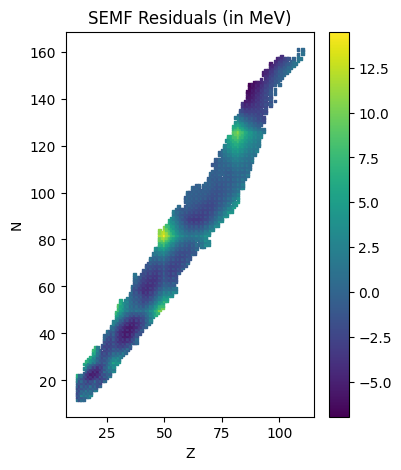

RMS error (in MeV): 3.0


In [ ]:
# Semi-Empirical Mass Formula (SEMF) fit

def volume(Z, N, aV):
    A = Z + N
    return aV * A

def surface(Z, N, aS):
    A = Z + N
    return aS * A ** (2 / 3)

def coulomb(Z, N, aC):
    A = Z + N
    return aC * Z * (Z - 1) / (A ** (1 / 3))

def asymmetry(Z, N, aA):
    A = Z + N
    return aA * (N - Z) ** 2 / A

@np.vectorize
def pairing(Z, N, aP):
    A = Z + N
    delta = aP * A ** (-1 / 2)
    if (Z % 2 == 1) and (N % 2 == 1):
        delta *= -1
    if (A % 1 == 1):
        delta = 0
    return delta

def semi_empirical_mass_formula(X, aV, aS, aC, aA, aP):
    Z, N = X
    B = (volume(Z, N, aV) - surface(Z, N, aS) - coulomb(Z, N, aC) - asymmetry(Z, N, aA) + pairing(Z, N, aP))
    return B

p0 = [0]*5
semf, pcov = curve_fit(semi_empirical_mass_formula, (zs,ns), data, p0, maxfev=10000000)

semf_res = semi_empirical_mass_formula((zs, ns),*semf)
plt.figure(figsize=(4,5))
plt.scatter(zs, ns, c=(data-semf_res)*1000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.xlabel("Z")
plt.ylabel("N")
plt.title("SEMF Residuals (in MeV)")
plt.show()

print("RMS error (in MeV): {:.1f}".format(rms(data, semf_res)*1000))


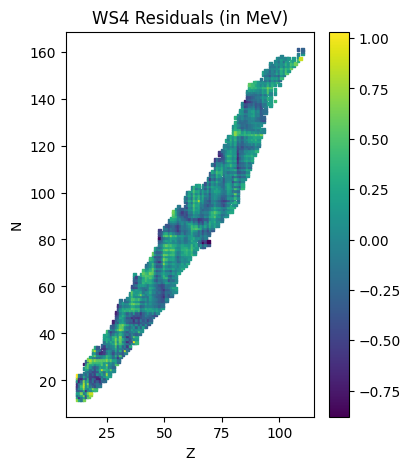

RMS error (in MeV): 0.279


In [5]:
# WS4 fit

plt.figure(figsize=(4,5))
plt.scatter(zs, ns, c=(data-ws4)*1000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.xlabel("Z")
plt.ylabel("N")
plt.title("WS4 Residuals (in MeV)")
plt.show()

print("RMS error (in MeV): {:.3f}".format(rms(data, ws4)*1000))

Text(0.5, 0.98, 'Principal Components (in MeV)')

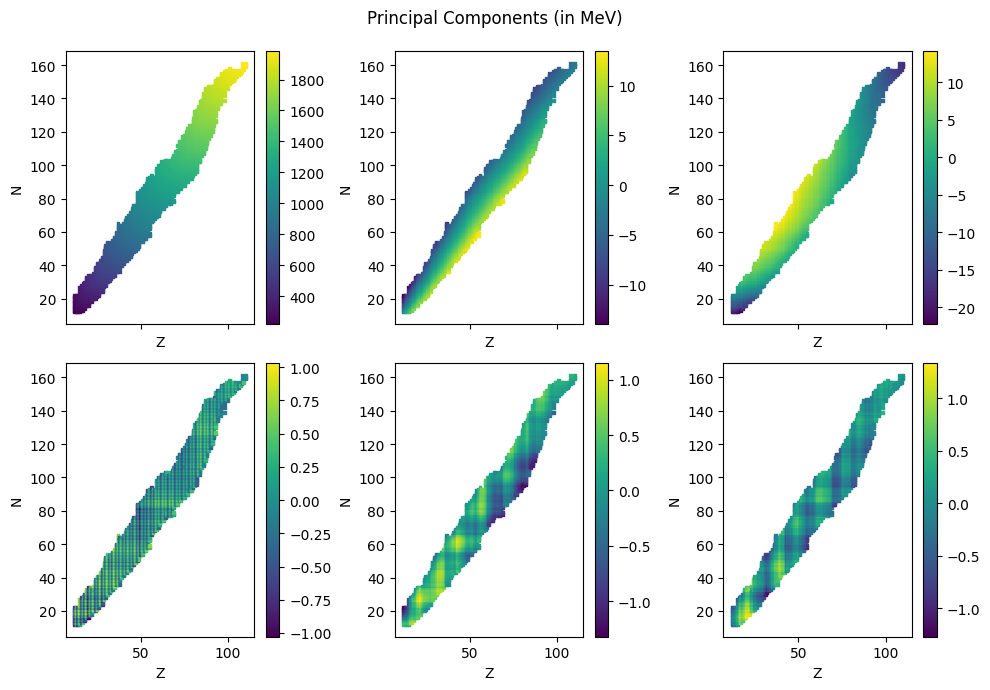

In [ ]:
# plot six most important PCs

pcs = [pc0, pc1, pc2, pc6, pc11, pc12]
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=False)
for i, (ax, y) in enumerate(zip(axs.flat, pcs), start=1):
    ax.scatter(zs, ns, c=y*1000, cmap="viridis", s=4, marker="s")
    ax.set_xlabel("Z")
    ax.set_ylabel("N")
    fig.colorbar(ax.collections[0], ax=ax)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle("Principal Components (in MeV)")


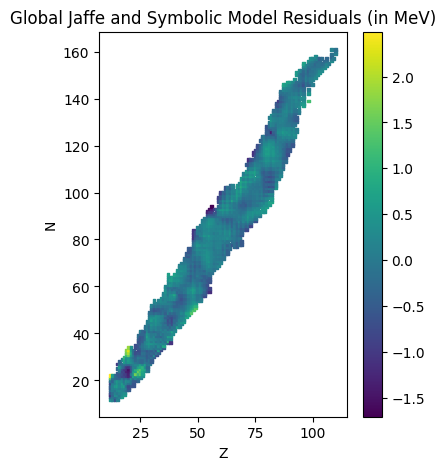

RMS error (in MeV): 0.372


In [7]:
# symbolic model and global Jaffe fit

def ws4_coulomb(Z, N, aC):
    A = Z + N
    return aC * Z**2 / A**(1/3) * (1 - 0.76 * Z**(-2/3))

def ws4_asymmetry(Z, N, cS, k, x, kS):
    A = Z + N
    I = (N - Z) / A
    aS = cS * (1 - k / A**(1/3) + x * (2 - np.abs(I)) / (2 + np.abs(I) * A))
    I0 = 0.4 * A / (A + 200)
    epsilon = (I - I0)**2 - I**4
    fS = 1 + kS * epsilon * A**(1/3)
    return aS * I**2 * A * fS

@np.vectorize
def ws4_pairing(N, Z, aP):
    A = N+Z
    res = aP*A**(-1/3)
    I = np.abs(N-Z)/A
    if (N%2)==0 and (Z%2)==0:
        res *= (2-I-I**2)*17./16.
    elif (N%2)==1 and (Z%2)==1:
        res *= I - (I**2)
    elif (N%2)==0 and (Z%2)==1 and N>Z:
        res *= 1-I
    elif (N%2)==1 and (Z%2)==0 and N<Z:
        res *= 1-I
    return res

def wigner(Z, N, aW):
    A = N + Z
    return aW * np.abs(N-Z)/A

def magic_nums_exp(N, Z, args):
    a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4, a5, b5, c5, a6, b6, c6 = args
    d1 = np.sqrt((N-82)**2 + (Z-50)**2)
    d2 = np.sqrt((N-126)**2 + (Z-82)**2)
    d3 = np.sqrt((N-50)**2 + (Z-50)**2)
    d4 = np.sqrt((N-28)**2 + (Z-28)**2)
    d5 = np.sqrt((N-50)**2 + (Z-28)**2)
    d6 = np.sqrt((N-82)**2 + (Z-82)**2)
    res = a1*np.exp(-b1*d1 + c1)
    res += a2*np.exp(-b2*d2 + c2)
    res += a3*np.exp(-b3*d3 + c3)
    res += a4*np.exp(-b4*d4 + c4)
    res += a5*np.exp(-b5*d5 + c5)
    res += a6*np.exp(-b6*d6 + c6)
    return res

def symbolic_macro_model(X, aV, aS, aC, cS, k, x, kS, aP, aW,
                         a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4, a5, b5, c5, a6, b6, c6):
    Z, N = X
    B = 0
    B += volume(Z, N, aV)
    B += surface(Z, N, aS)
    B += ws4_coulomb(Z, N, aC)
    B += ws4_asymmetry(Z, N, cS, k, x, kS)
    B += ws4_pairing(N, Z, aP)
    B += wigner(Z, N, aW)
    B += magic_nums_exp(N, Z,
                         (a1, b1, c1,
                          a2, b2, c2,
                          a3, b3, c3,
                          a4, b4, c4,
                          a5, b5, c5, 
                          a6, b6, c6))
    return B

def vector_help(Z, N, cN, cZ):
    iZ = Z - 12
    iN = N - 12
    return cN[int(iN)] + cZ[int(iZ)]

def global_jaffe(X, *args): 
    Z, N = X
    vg = np.vectorize(vector_help, excluded=['cN','cZ'])
    params = args[:27]
    cZ = args[27:126]
    cN = args[126:]
    return vg(Z=Z, N=N, cZ=cZ, cN=cN)+symbolic_macro_model((np.array(Z), np.array(N)),*params)

def global_jaffe_regularized(N, Z, gaussian_lambda, sigma_scale, reg_lambda, target, gauss_params):
    def min_this(params):
        res = global_jaffe((Z, N), *params)
        data_resid = res - target

        gaussian_resid = []
        for i in range(8):
            deviation = params[i] - gauss_params[i]
            gaussian_resid.append(gaussian_lambda * (deviation**2) / (sigma_scale*gauss_params[i]**2))

        microcorrections = list(params)
        reg_resid = []
        for m in microcorrections:
            reg_resid.append(reg_lambda * np.abs(m))

        return np.concatenate((data_resid, gaussian_resid, reg_resid))
    
    return min_this

# p0 = [0.015328347, -0.0177686087, -0.000693192105, -0.0327599849, 1.95330806, 1.3526193, 0.248612616, 0.00669600662, 0.00842983404, -5.96883407, -2.27211741e-05, 1.62710833, 0.0291717458, 0.0557150016, -0.0960729365, 0.00127486628, -0.0327941757, 0.0288392475, 3.06821236, 9.98092217e-06, 2.56655348, -1.87175214, 4.55446055e-05, 1.62839161, 0.0472693869, 0.204524775, 0.101196107, -0.000321384658, 0.000188802725, 0.00118528533, 0.00133268254, 0.000674884723, 0.000805733813, 0.000294211456, 0.000550588531, 0.0006443525, -0.000131496224, -0.000794296013, -0.000721159767, -0.00103205052, -0.000413829278, -0.000287458335, 0.00024648399, 0.000780754121, 0.000795901217, -6.13371877e-05, -0.000239486893, -0.00102070164, -0.00137477358, -0.0019166596, -0.00221208682, -0.00250342028, -0.00256014341, -0.00263003152, -0.00265528724, -0.003009022, -0.00319053052, -0.00326911944, -0.00316817839, -0.00294059319, -0.00261992325, -0.00246672394, -0.00198900572, -0.00155732865, -0.000866535262, -0.00014225449, -0.000735218869, -0.00154764656, -0.00188537456, -0.00227835465, -0.00242128341, -0.00254005538, -0.00245295066, -0.00245602465, -0.00239701326, -0.00224637303, -0.00198755233, -0.00191282762, -0.00150579631, -0.00137222326, -0.00103431459, -0.000913997177, -0.000705563121, -0.000578144118, -0.000374622989, -0.000254066687, -0.000115368041, -0.000172440967, 4.48181485e-05, 0.00011229988, 0.000330357837, 0.000423571387, 0.000583417356, 0.000688649107, 0.00108334551, 0.00134307514, 0.00179777262, 0.00185401535, 0.00139513285, 0.0009954736, 0.000804382509, 0.000682678355, 0.000799097078, 0.00094638739, 0.00124234672, 0.00149785966, 0.00191705342, 0.00225645319, 0.00278821166, 0.00304318177, 0.00357416087, 0.00363511207, 0.00387453661, 0.00385169336, 0.00403470983, 0.00373298336, 0.00387428144, 0.00329590772, 0.00330220867, 0.00278036102, 0.00281155162, 0.00221647636, 0.00199157491, 0.00108143017, 0.000710502195, -0.00091468383, 0.00426336906, 0.00432212449, 0.00485501392, 0.004870585, 0.0038803164, 0.00357984166, 0.00259442103, 0.00228660131, 0.00170001788, 0.000718700959, 0.000143925132, 0.000119139924, 0.000246743411, 0.000739221048, 0.00101480019, 0.00168366646, 0.00252524542, 0.00291724519, 0.00231384733, 0.00257286585, 0.00216248061, 0.00227930492, 0.00178296502, 0.00173868997, 0.00182271577, 0.00190052026, 0.00208102952, 0.00229029444, 0.00260911216, 0.00287263845, 0.00340394669, 0.00382263004, 0.00448619189, 0.00506585605, 0.00579831459, 0.00662963435, 0.00751476668, 0.00844770273, 0.00935322257, 0.00883327521, 0.00756994644, 0.00688290026, 0.00564776533, 0.00486486046, 0.00364794855, 0.00270509389, 0.00146806064, 0.000495819759, -0.000259390158, -0.000969342358, -0.00162237728, -0.00231676227, -0.00289187125, -0.00356957415, -0.00408505942, -0.00469976395, -0.0050088938, -0.00551985405, -0.00571606369, -0.00617436058, -0.00625873469, -0.00663409771, -0.00653911755, -0.00672027017, -0.00650687457, -0.00637975372, -0.00609096688, -0.00581170163, -0.00516823144, -0.00442738564, -0.00369571389, -0.00437579334, -0.00530677245, -0.00568778863, -0.00631688539, -0.0066141667, -0.00680545388, -0.00684863329, -0.00652713659, -0.00618999557, -0.00555134134, -0.00506132427, -0.00431104599, -0.0037251274, -0.00314013098, -0.00270902591, -0.00225403632, -0.00180750507, -0.00150198892, -0.00107276118, -0.000787138023, -0.0004917412, -0.0003264769, -0.000158323871, 3.56869778e-05, 0.000156371826, 0.000382184868, 0.000350847548, 0.000476819739, 0.000432499234, 0.000547323267, 0.000520916001, 0.000634301059, 0.000733855069, 0.000820045638, 0.000821449456, 0.000932051601, 0.000977628863, 0.000926224963, 0.000987071751, 0.000931591047, 0.00103828136, 0.00103502608, 0.00140659226, 0.00128023407, 0.000736930826, 0.000366410952, 0.000300807685, 0.000255241157, 0.000276454091, 0.000534849948, 0.0008322347, 0.000944285161, 0.00124179795, 0.00154197558, 0.00185261661, 0.00219174656, 0.00250817054, 0.00285630791, 0.00316097921, 0.00335904427, 0.00356363958, 0.00358803241, 0.00375718441, 0.00347308852, 0.00337713443, 0.00280444821, 0.00270424351, 0.00207234291, 0.0017934512, 0.00105613357, 0.000356481132, -0.000801578338, -0.00169835341, -0.0029588456, -0.00399159959, -0.00535287139, -0.00639828749, -0.00769480204, -0.00892528489]
# gaussian_lambda = 1e-3
# sigma_scale = 0.1
# reg_lambda = 1.025e-2
    
# popt = least_squares(global_jaffe_regularized(ws4_ns_filtered, ws4_zs_filtered, gaussian_lambda, sigma_scale, reg_lambda, data_for_ws4, p0[:8]), p0)

# for speed
args = [0.013540262084667952, -0.012473029923269485, -0.0006121884579451572, -0.023224169311075963, 0.8527939817548712, 0.39074737390450315, 0.1610140948576897, 0.0058964736598910794, -0.014245806742948203, -0.08482927370332106, -0.011615278713237512, 0.007196890546677325, 0.10489925631388798, 0.013560183770261977, 0.010994120802992233, 0.0014885544183308769, -0.04088103358391781, 6.714765782183083e-06, 0.09102141780005991, 0.004263172405916091, 0.00897177352768426, 0.0558499303020941, -0.00040225761207392154, 0.0032448155803532002, 0.03880295817018245, 0.1734377607257672, 0.0015206084687598392, 0.009347553136302006, 0.008321702604722361, 0.008271409395007319, 0.0074915092880637095, 0.005972921480441228, 0.004926748107709484, 0.003592597420838512, 0.0029444874397297326, 0.0022328244468562, 0.0004643996206681207, -0.0009531387675188526, -0.001675679501618412, -0.002552254453079678, -0.0027012344778940666, -0.003154122201682486, -0.0032632258160727986, -0.003259655957550339, -0.003879573576131011, -0.005160828134999652, -0.005792260119846964, -0.006771191981378416, -0.007460581801623589, -0.008085419422135403, -0.00858720311585272, -0.008804179252753085, -0.008967960206733107, -0.009044026496991962, -0.009098787541262653, -0.009357888083450576, -0.00958978564862001, -0.009559429905509516, -0.009524160171858516, -0.009179597192588516, -0.008923782870402748, -0.008670570516634744, -0.008260228365443358, -0.0078921773869288, -0.007227514057769379, -0.006461890325920289, -0.007033154111353028, -0.007652733162658702, -0.007891429128619006, -0.008013679370682657, -0.007988733128339403, -0.007682695951413784, -0.007369958750987945, -0.006986200586918797, -0.0066911990115816255, -0.006143689323395118, -0.005599224177471103, -0.00510451903645457, -0.004466769385463691, -0.0039122419550587885, -0.003308006405071363, -0.0028252500724380574, -0.0023999763944374075, -0.0018788630003176736, -0.0014473908344661602, -0.0009318279332060559, -0.0005595844126400787, -0.0002637022232955086, 0.00023333373645121269, 0.0006783904483776255, 0.0011629571364613152, 0.0016533243474247173, 0.0021088673142440335, 0.002621204044787749, 0.0033557351381000677, 0.004054905113548457, 0.004869036498484937, 0.005451837759617827, 0.0054843678542072175, 0.005669576244011484, 0.0060139046407260335, 0.006563798072316782, 0.007273837101812406, 0.008115382110369246, 0.00898158077093498, 0.009893738466140677, 0.010818916190348346, 0.011754477491332915, 0.01269751455000782, 0.013351175565000102, 0.014027154953182458, 0.014505585105959415, 0.014574755840515652, 0.0147911506295236, 0.014694433922805103, 0.014214961839590739, 0.013905858518999331, 0.012836452502599247, 0.012154785567193552, 0.01099353955957443, 0.010114101383065533, 0.008475031268427458, 0.007309897461853422, 0.004773486113231311, 0.002892220740905185, -0.0004162923640808774, 0.03351218363615892, 0.03220467020663664, 0.031643898187893024, 0.030365625362810674, 0.028274553428438813, 0.026770787397759666, 0.0247872889992964, 0.02338477341805077, 0.0218528423070721, 0.019800677336203155, 0.018392737008920985, 0.017067698350128436, 0.016196764593287404, 0.01574969671721322, 0.015148121052827253, 0.014909148473385906, 0.014771772390450563, 0.014132043385604103, 0.012608194148356273, 0.01178375980159349, 0.010521889683208706, 0.009655565987269443, 0.008197870204982746, 0.007036617195572677, 0.006050243718783672, 0.005273075385018551, 0.004615604808317809, 0.0038986311075815843, 0.003365751069137324, 0.002701508398524297, 0.002420740424479072, 0.0019570751771810515, 0.0019270704037656142, 0.001728044075592346, 0.0018720267760620043, 0.002028625057166276, 0.0024332388591593915, 0.0028076893284406973, 0.0034113863650305615, 0.0024688726557561733, 0.0009461024758167349, -8.367352624863708e-05, -0.0014817447772042162, -0.002591972624324942, -0.003978273592229767, -0.005208748208058594, -0.006626166015925281, -0.007856883047286057, -0.008709123214981598, -0.00966781371388011, -0.010437562793221047, -0.01133896043344021, -0.011998863309419091, -0.012914587671150123, -0.013591488978822622, -0.01442928382325233, -0.014867314530117538, -0.015600736838350391, -0.01591863530392697, -0.016552718142718182, -0.01673107303759705, -0.01726732824458216, -0.017288197519636724, -0.017601779349680807, -0.017428949103259164, -0.017446519696654984, -0.017168692426706347, -0.01691721580808846, -0.01617081596873918, -0.015420428504566467, -0.014528167528166784, -0.015071741659235692, -0.015658121108241517, -0.015792856994523773, -0.016048949023183063, -0.016102123645779013, -0.015944318912582623, -0.01574662066413743, -0.01506667293366311, -0.014504544163995863, -0.013534169401156568, -0.01279197558042866, -0.011704692160819513, -0.01086388619306431, -0.009936366482065319, -0.00921496486161518, -0.008399881894840153, -0.007666189598378611, -0.006984102532812992, -0.006250985970036988, -0.005619972532990751, -0.0050054518872312895, -0.00441116880512882, -0.0039298222227797976, -0.0033625637938180103, -0.0029637135597081984, -0.0023298318081152927, -0.0020390706545518355, -0.0015284257934994037, -0.0012617530623854857, -0.0007652618937548697, -0.00048148112941203254, 3.7174202913507286e-05, 0.0005302063782661498, 0.0009925369157168474, 0.001327821782029304, 0.0018857762760668222, 0.0023164162300950237, 0.0027125185414788784, 0.003208409482116677, 0.0035981622912971438, 0.004138137161631994, 0.0046391144392087654, 0.005500941579063442, 0.005907594972894868, 0.005786784704264066, 0.005882282140004575, 0.00629124930024324, 0.006764716112586277, 0.007225336356536424, 0.007924894020948918, 0.008617035550252667, 0.009224364715003916, 0.009843278169036754, 0.010517690975513942, 0.011112882085366328, 0.011737969675519957, 0.012244889406699929, 0.012677793678955338, 0.012980274217636237, 0.013230620441703856, 0.013274201748578305, 0.013119498317323779, 0.012967746365723445, 0.012359351948833603, 0.01160799771547943, 0.01030655184850617, 0.009353898568943402, 0.007858882572643057, 0.006474161753170904, 0.0044820138198640195, 0.0022113047598975163, -0.0005658007433933439, -0.0034371654383779323, -0.006789789207955157, -0.010263632138836689, -0.01430341630198232, -0.01886053328229956, -0.023713363580468706, -0.028596286354081575]

res_global_jaffe = global_jaffe((zs, ns),*args)
plt.figure(figsize=(4,5))
plt.scatter(zs, ns, c=(data-res_global_jaffe)*1000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.xlabel("Z")
plt.ylabel("N")
plt.title("Global Jaffe and Symbolic Model Residuals (in MeV)")
plt.show()  

print("RMS error (in MeV): {:.3f}".format(rms(data, res_global_jaffe)*1000))


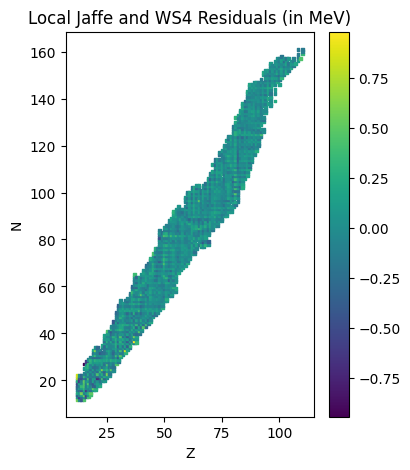

RMS error (in MeV): 0.157


In [8]:
# Only isoto(p,n)ic (next-to-)nearest neighbors

factors = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]

    if current_n==current_z and current_n%2==1:
        continue

    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        if correction_n==correction_z and correction_n%2==1:
            continue

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if (current_z==correction_z and dn>=1 and dn<=2) or (current_n==correction_n and dz>=1 and dz<=2):
            factors[i] += 1./np.sqrt(dz**2 + dn**2)

corrections = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]

    if current_n==current_z and current_n%2==1:
        continue

    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        if correction_n==correction_z and correction_n%2==1:
            continue

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if (current_z==correction_z and dn>=1 and dn<=2) or (current_n==correction_n and dz>=1 and dz<=2):
            correction_eb = ws4[j]
            correction_data = data[j]
            numer = correction_data - correction_eb
            denom = np.sqrt(dz**2 + dn**2)
            corrections[i] += numer / denom / factors[i]

local_ws4_res = ws4 + corrections

plt.figure(figsize=(4,5))
plt.scatter(zs, ns, c=(data-local_ws4_res)*1000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.xlabel("Z")
plt.ylabel("N")
plt.title("Local Jaffe and WS4 Residuals (in MeV)")
plt.show()  

print("RMS error (in MeV): {:.3f}".format(rms(local_ws4_res, data)*1000))


In [9]:
# All nearest neighbors

factors = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]
    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if dn <= 1 and dz <= 1:
            if current_n == correction_n and current_z == correction_z:
                continue
            else:
                factors[i] += 1./np.sqrt(dz**2 + dn**2)

corrections = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]

    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if dn <= 1 and dz <= 1:
            if current_n == correction_n and current_z == correction_z:
                continue
            else:
                correction_eb = ws4[j]
                correction_data = data[j]
                numer = correction_data - correction_eb
                denom = np.sqrt(dz**2 + dn**2)
                corrections[i] += numer / denom / factors[i]

res = ws4 + corrections
                
print("RMS error using all nearest neighbors (in MeV): {:.3f}".format(rms(res, data)*1000))


RMS error using all nearest neighbors (in MeV): 0.207


In [10]:
# Only isoto(p,n)ic nearest neighbors

factors = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]

    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if (current_z==correction_z and dn==1) or (current_n==correction_n and dz==1):
            factors[i] += 1./np.sqrt(dz**2 + dn**2)

corrections = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]

    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if (current_z==correction_z and dn==1) or (current_n==correction_n and dz==1):
            correction_eb = ws4[j]
            correction_data = data[j]
            numer = correction_data - correction_eb
            denom = np.sqrt(dz**2 + dn**2)
            corrections[i] += numer / denom / factors[i]

res = ws4 + corrections
                
print("RMS error using only isoto(p,n)ic nearest neighbors (in MeV): {:.3f}".format(rms(res, data)*1000))


RMS error using only isoto(p,n)ic nearest neighbors (in MeV): 0.175


In [11]:
# Only non-isoto(p,n)ic nearest neighbors
    
factors = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]
    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if dn==1 and dz==1:
            factors[i] += 1./np.sqrt(dz**2 + dn**2)

corrections = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]

    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if dn==1 and dz==1:
            correction_eb = ws4[j]
            correction_data = data[j]
            numer = correction_data - correction_eb
            denom = np.sqrt(dz**2 + dn**2)
            corrections[i] += numer / denom / factors[i]

res = ws4 + corrections
                
print("RMS error using only non-isoto(p,n)ic nearest neighbors (in MeV): {:.3f}".format(rms(res, data)*1000))


RMS error using only non-isoto(p,n)ic nearest neighbors (in MeV): 0.277


In [12]:
# Only isoto(p,n)ic next-to-nearest neighbors
    
factors = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]
    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if (current_z==correction_z and dn==2) or (current_n==correction_n and dz==2):
            factors[i] += 1./np.sqrt(dz**2 + dn**2)

corrections = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]

    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if (current_z==correction_z and dn==2) or (current_n==correction_n and dz==2):
            correction_eb = ws4[j]
            correction_data = data[j]
            numer = correction_data - correction_eb
            denom = np.sqrt(dz**2 + dn**2)
            corrections[i] += numer / denom / factors[i]

res = ws4 + corrections
                
print("RMS error using only isoto(p,n)ic next-to-nearest neighbors (in MeV): {:.4f}".format(rms(res, data)*1000))


RMS error using only isoto(p,n)ic next-to-nearest neighbors (in MeV): 0.1865


In [13]:
# Only isoto(p,n)ic (next-to-)nearest neighbors

factors = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]
    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if (current_z==correction_z and dn>=1 and dn<=2) or (current_n==correction_n and dz>=1 and dz<=2):
            factors[i] += 1./np.sqrt(dz**2 + dn**2)

corrections = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]

    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if (current_z==correction_z and dn>=1 and dn<=2) or (current_n==correction_n and dz>=1 and dz<=2):
            correction_eb = ws4[j]
            correction_data = data[j]
            numer = correction_data - correction_eb
            denom = np.sqrt(dz**2 + dn**2)
            corrections[i] += numer / denom / factors[i]

res = ws4 + corrections
                
print("RMS error using only isoto(p,n)ic (next-to-)nearest neighbors (in MeV): {:.3f}".format(rms(res, data)*1000))


RMS error using only isoto(p,n)ic (next-to-)nearest neighbors (in MeV): 0.160


In [14]:
# Only non-isoto(p,n)ic (next-to-)nearest neighbors
    
factors = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]
    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if dn>=1 and dn<=2 and dz>=1 and dz<=2:
            factors[i] += 1./np.sqrt(dz**2 + dn**2)

corrections = np.zeros_like(ws4)
for i in range(len(ws4)):
    current_z = zs[i]
    current_n = ns[i]

    for j in range(len(ws4)):
        correction_n = ns[j]
        correction_z = zs[j]

        dn = np.abs(current_n-correction_n)
        dz = np.abs(current_z-correction_z)

        if dn>=1 and dn<=2 and dz>=1 and dz<=2:
            correction_eb = ws4[j]
            correction_data = data[j]
            numer = correction_data - correction_eb
            denom = np.sqrt(dz**2 + dn**2)
            corrections[i] += numer / denom / factors[i]

res = ws4 + corrections
                
print("RMS error using only non-isoto(p,n)ic (next-to-)nearest neighbors (in MeV): {:.3f}".format(rms(res, data)*1000))


RMS error using only non-isoto(p,n)ic (next-to-)nearest neighbors (in MeV): 0.242


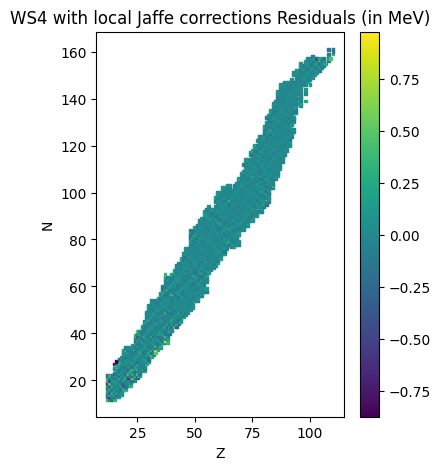

RMS error using improved local Jaffe corrections (in MeV): 0.115
RMS error using improved local Jaffe corrections with 20-24 (next-to-)nearest neighbors (in MeV): 0.094
RMS error using improved local Jaffe corrections with 11-19 (next-to-)nearest neighbors (in MeV): 0.160
RMS error using improved local Jaffe corrections with 1-10 (next-to-)nearest neighbors (in MeV): 0.207


In [17]:
# WS4 with improved local Jaffe corrections fit 

ws4_dict = {}
data_dict = {}
gk_data_dict = {}
gk_ws4_dict = {}
for n,z,d,w in zip(ns,zs,data,ws4):
    ws4_dict[(n,z)] = w
    data_dict[(n,z)] = d
    if n==z and n%2==1:
        continue
    gk_data_dict[(n,z)] = d
    gk_ws4_dict[(n,z)] = d-w

def count_neighbors(n,z):
    count = 0
    r = [-2,-1,0,1,2]
    for i in r:
        for j in r:
            if i==0 and j==0:
                continue
            if (n+i,z+j) in ws4_dict.keys():
                count += 1
    return count

def count_nearest_neighbors(n,z):
    count = 0
    r = [-1,0,1]
    for i in r:
        for j in r:
            if i==0 and j==0:
                continue
            if (n+i,z+j) in ws4_dict.keys():
                count += 1
    return count

def chi2simple(alphas,n,z):
    r = [-2,-1,0,1,2]
    if n<16 or z<16:
        r = [-1,0,1]
    residual = 0
    for i in r:
        for j in r:
            if i==0 and j==0:
                continue
            if (n+i,z+j) in gk_data_dict.keys():
                alpha_n = alphas[i+2]
                alpha_z = alphas[j+2+5]
                residual += (data_dict[(n+i,z+j)] - ws4_dict[(n+i,z+j)] - alpha_n - alpha_z)**2
    return residual

chi2_res = []
count = 0
for n,z,l in zip(ns,zs,local_ws4_res):
    if  count_neighbors(n,z) < 7 or (n==z and n%2==1) or count_nearest_neighbors(n,z)<3:
        chi2_res.append(l)
        continue

    p0 = [0]*10
    popt = minimize(chi2simple, p0, args=(n,z))
    alpha_n = popt.x[2]
    alpha_z = popt.x[7]
    r = ws4_dict[(n,z)] + alpha_n + alpha_z
    chi2_res.append(r)

chi2_res = np.array(chi2_res)

plt.figure(figsize=(4,5))
plt.scatter(zs, ns, c=(data-chi2_res)*1000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.xlabel("Z")
plt.ylabel("N")
plt.title("WS4 with local Jaffe corrections Residuals (in MeV)")
plt.show()  

print("RMS error using improved local Jaffe corrections (in MeV): {:.3f}".format(rms(chi2_res, data)*1000))

high_n_pred = []
high_n_data = []
med_n_pred = []
med_n_data = []
low_n_pred = []
low_n_data = []
for n,z,w,d in zip(ns,zs,chi2_res,data):
    n_n = count_neighbors(n,z)
    if n_n>=20:
        high_n_pred.append(w)
        high_n_data.append(d)
    elif n_n>=11:
        med_n_pred.append(w)
        med_n_data.append(d)
    elif n_n>=1:
        low_n_pred.append(w)
        low_n_data.append(d)

high_n_pred = np.array(high_n_pred)
high_n_data = np.array(high_n_data)
med_n_pred = np.array(med_n_pred)
med_n_data = np.array(med_n_data)
low_n_pred = np.array(low_n_pred)
low_n_data = np.array(low_n_data)

print("RMS error using improved local Jaffe corrections with 20-24 (next-to-)nearest neighbors (in MeV): {:.3f}".format(rms(high_n_pred, high_n_data)*1000))
print("RMS error using improved local Jaffe corrections with 11-19 (next-to-)nearest neighbors (in MeV): {:.3f}".format(rms(med_n_pred, med_n_data)*1000))
print("RMS error using improved local Jaffe corrections with 1-10 (next-to-)nearest neighbors (in MeV): {:.3f}".format(rms(low_n_pred, low_n_data)*1000))
